In [37]:
import pandas as pd
import numpy as np
import json
from scipy import sparse as sp
from tqdm.notebook import tqdm
from collections import defaultdict

In [2]:
import implicit

In [3]:
import sys
sys.path.append('../')

from src.utils import get_shard_path
from src.utils import ProductEncoder, make_coo_row
from src.metrics import normalized_average_precision

In [4]:
product_encoder = ProductEncoder('../data/raw/products.csv')

In [5]:
valid_data = [json.loads(l) for l in open(get_shard_path(7))][:3000]

In [20]:
def make_coo_row(transaction_history, product_encoder: ProductEncoder):
    idx = []
    values = []

    items = []
    for trans in transaction_history:
        items.extend([i["product_id"] for i in trans["products"]])
    n_items = len(items)

    for pid in items:
        idx.append(product_encoder.toIdx(pid))
        values.append(1.0 / n_items)

    return sp.coo_matrix(
        (np.array(values).astype(np.float32), ([0] * len(idx), idx)), shape=(1, product_encoder.num_products),
    )

In [21]:
rows = []
for shard_id in range(4):
    for js in tqdm(json.loads(l) for l in open(get_shard_path(shard_id))):
        rows.append(make_coo_row(js["transaction_history"], product_encoder))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [22]:
X_sparse = sp.vstack(rows).tocsr()

In [23]:
X_sparse.shape

(92161, 43038)

# Cosine

In [29]:
model = implicit.nearest_neighbours.CosineRecommender(K=200)
model.fit(X_sparse)

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.04799962043762207 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

In [30]:
m_ap = []
for js in tqdm(valid_data):
    row_sparse = make_coo_row(js["transaction_history"], product_encoder).tocsr()
    raw_recs = model.recommend(0, row_sparse, N=30, filter_already_liked_items=False, recalculate_user=True)
    recommended_items = product_encoder.toPid([x for x in raw_recs[0]])
    gt_items = js["target"][0]["product_ids"]
    m_ap.append(normalized_average_precision(gt_items, recommended_items, k=30))
print(np.mean(m_ap))

  0%|          | 0/3000 [00:00<?, ?it/s]

0.11309912730549081


In [40]:
K = []
metr = []
for i in range(1, 200, 10):
    model = implicit.nearest_neighbours.CosineRecommender(K=i)
    model.fit(X_sparse)
    m_ap = []
    for js in tqdm(valid_data):
        row_sparse = make_coo_row(js["transaction_history"], product_encoder).tocsr()
        raw_recs = model.recommend(0, row_sparse, N=30, filter_already_liked_items=False, recalculate_user=True)
        recommended_items = product_encoder.toPid([x for x in raw_recs[0]])
        gt_items = js["target"][0]["product_ids"]
        m_ap.append(normalized_average_precision(gt_items, recommended_items, k=30))
    K.append(i)
    metr.append(np.mean(m_ap))
#     print("k = ", K, "m_ap = ", np.mean(m_ap))

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0475764274597168 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.06977486610412598 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.04926252365112305 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.044816017150878906 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.04366707801818848 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.042168378829956055 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.046622276306152344 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.04512381553649902 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.046030282974243164 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.04800748825073242 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.05002927780151367 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.046924591064453125 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.04931020736694336 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.04305148124694824 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.048926353454589844 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.04328584671020508 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.04718828201293945 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.043036460876464844 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.05062532424926758 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.042601585388183594 seconds
  warnings.warn(


  0%|          | 0/43038 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [38]:
import matplotlib.pyplot as plt

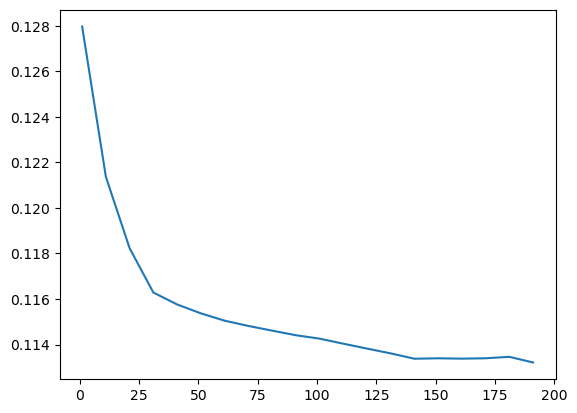

In [41]:
plt.plot(K, metr)
plt.show()

In [ ]:
import pickle
pickle.dump(model, open("../tmp/i2i/cosine.pkl", "wb"))